In [2]:
!pip install librosa

  Obtaining dependency information for librosa from https://files.pythonhosted.org/packages/8c/8a/2d231b35456506b7c98b3ab9bbf07917b205fed8615d2e59e976ab497fff/librosa-0.10.2.post1-py3-none-any.whl.metadata
  Obtaining dependency information for audioread>=2.1.9 from https://files.pythonhosted.org/packages/57/8d/30aa32745af16af0a9a650115fbe81bde7c610ed5c21b381fca0196f3a7f/audioread-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for soundfile>=0.12.1 from https://files.pythonhosted.org/packages/50/ff/26a4ee48d0b66625a4e4028a055b9f25bc9d7c7b2d17d21a45137621a50d/soundfile-0.12.1-py2.py3-none-win_amd64.whl.metadata
  Obtaining dependency information for pooch>=1.1 from https://files.pythonhosted.org/packages/a8/87/77cc11c7a9ea9fd05503def69e3d18605852cd0d4b0d3b8f15bbeb3ef1d1/pooch-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for soxr>=0.3.2 from https://files.pythonhosted.org/packages/86/94/6a7e91bea7e6ca193ee429869b8f18548cd79759e064021ecb5756024c7c

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [32]:
import os
import pandas as pd

# Define the directory
directory = 'D:\SER\TESS Toronto emotional speech set data'

# Initialize lists to store paths and labels
paths = []
labels = []
for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('_')[0][::-1]  
        labels.append(label.lower())  
data = pd.DataFrame({'speech': paths, 'label': labels})
print(data.sample(5))


                                                 speech        label
633   D:\SER\TESS Toronto emotional speech set data\...    happy.wav
677   D:\SER\TESS Toronto emotional speech set data\...    happy.wav
3116  D:\SER\TESS Toronto emotional speech set data\...  disgust.wav
3339  D:\SER\TESS Toronto emotional speech set data\...     fear.wav
1117  D:\SER\TESS Toronto emotional speech set data\...       ps.wav


In [7]:
data['label'].value_counts()

label
angry.wav      800
disgust.wav    800
fear.wav       800
happy.wav      800
neutral.wav    800
ps.wav         800
sad.wav        800
Name: count, dtype: int64

In [8]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    
def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    display(Audio(path))

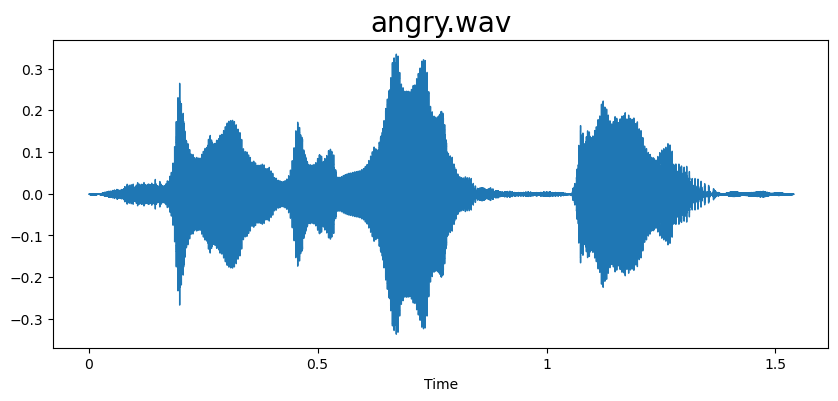

None

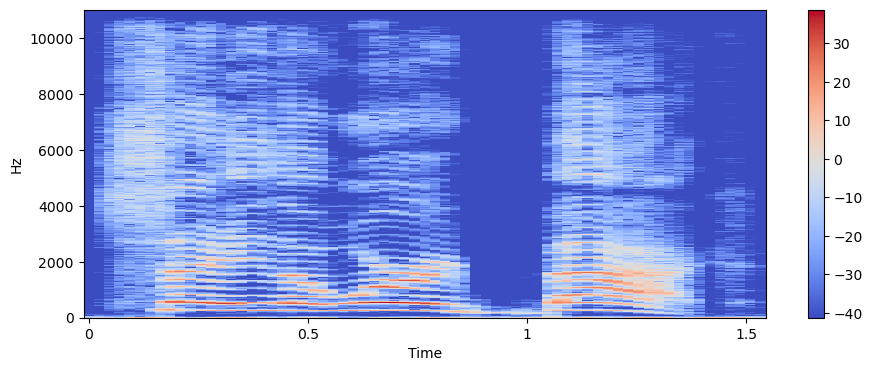

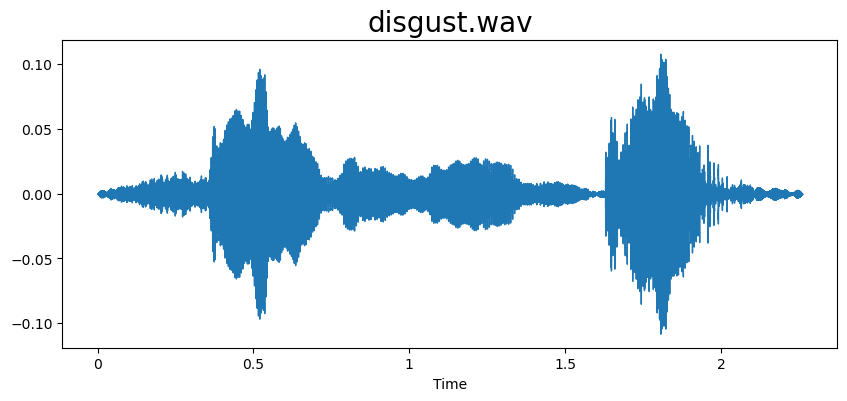

None

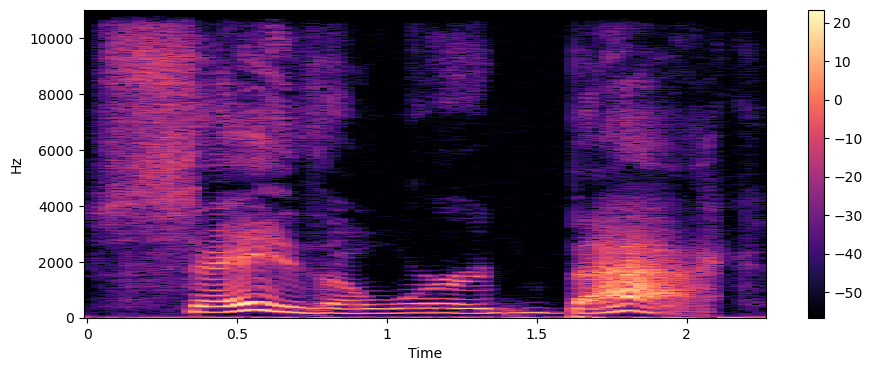

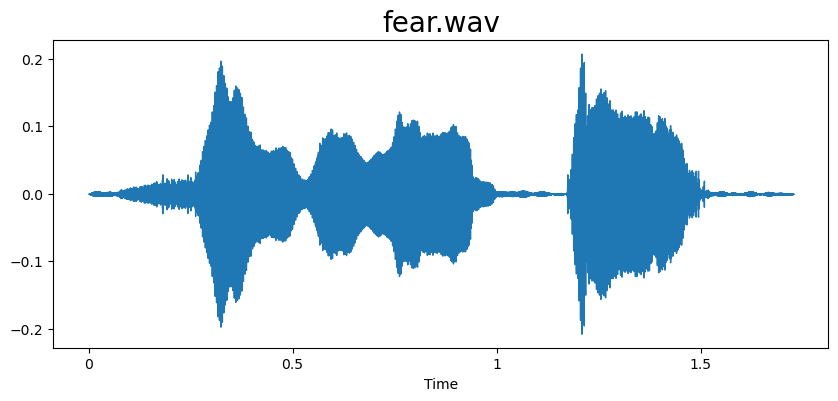

None

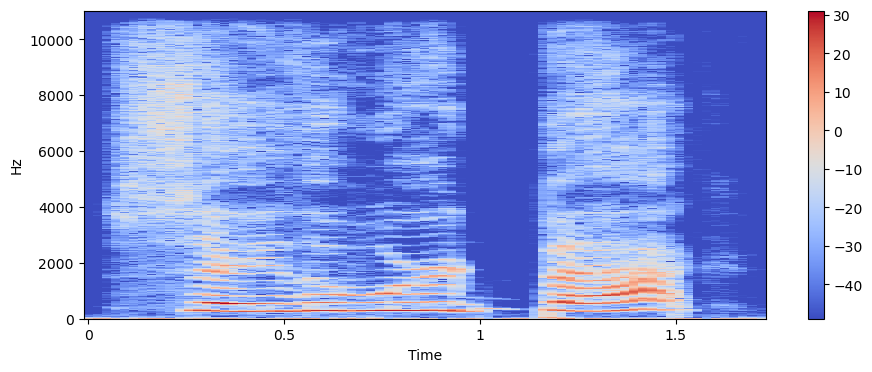

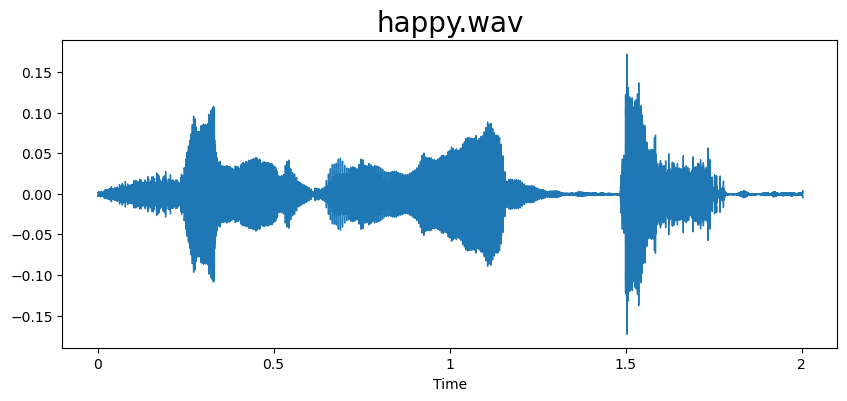

None

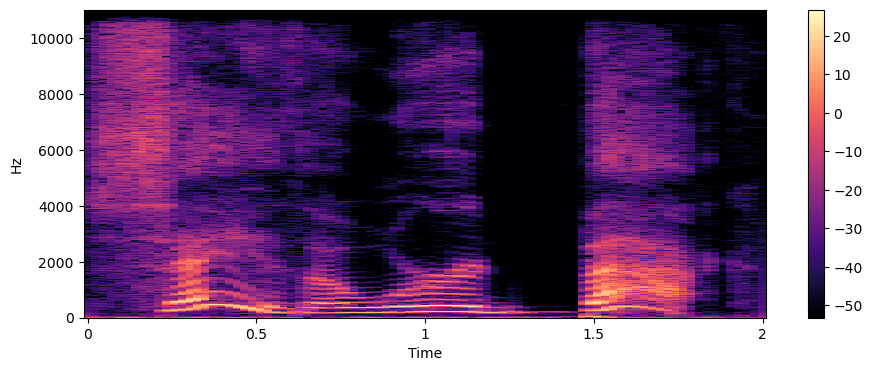

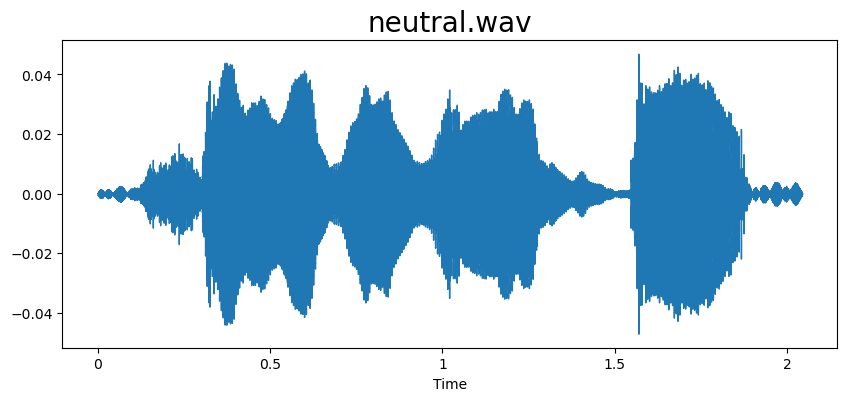

None

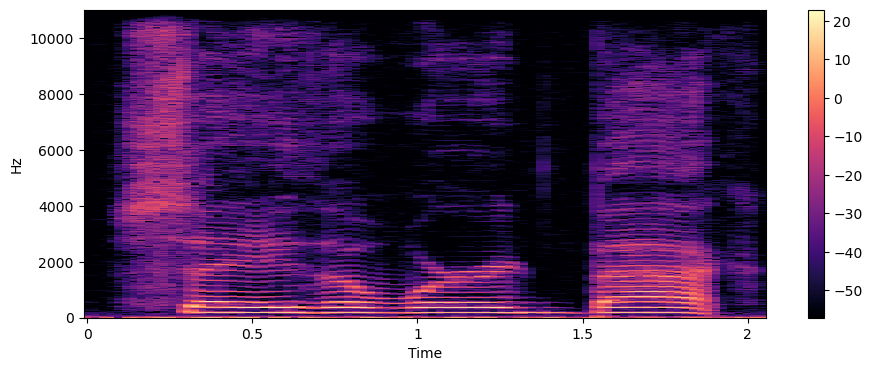

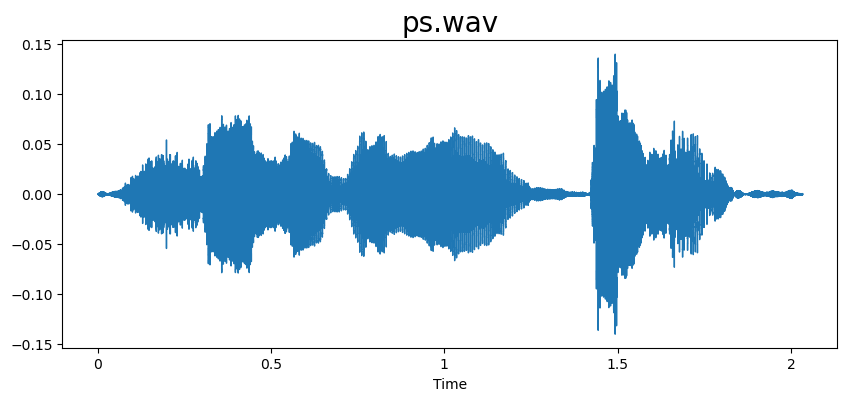

None

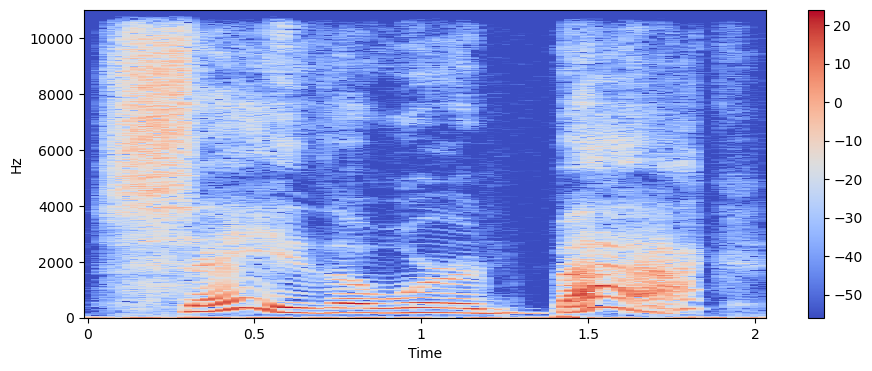

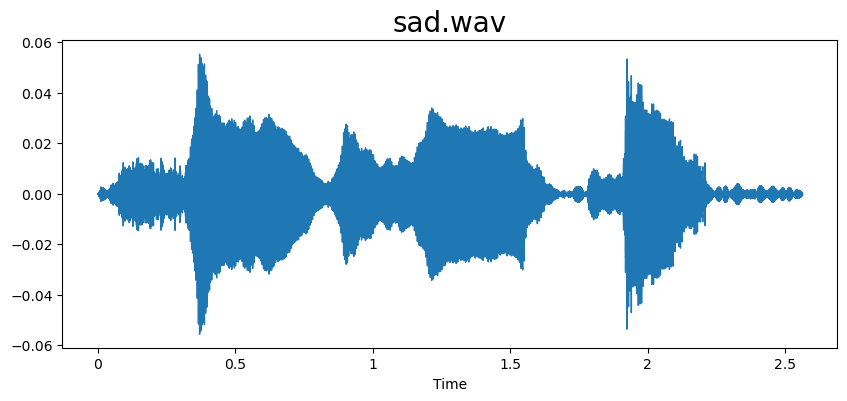

None

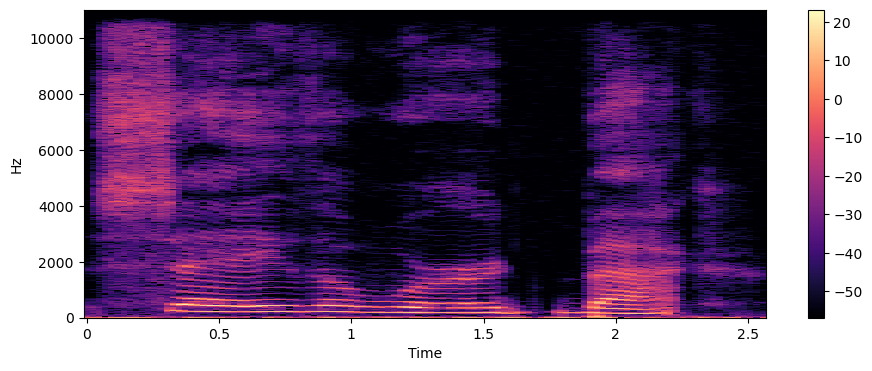

In [9]:
for i in list(data['label'].unique()):
    display(ana_emotion(i, data))

In [10]:
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [12]:
X=[x for x in mfcc]
X=np.array(X)
X.shape
X=np.expand_dims(X,-1)
X.shape

(5600, 40, 1)

In [13]:
ohe=OneHotEncoder()
y = ohe.fit_transform( data[['label']] )
y= y.toarray()

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model=Sequential([
    LSTM(256,return_sequences=False,input_shape=(40,1)),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(64,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=50,batch_size=56)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9872 - loss: 0.0451 - val_accuracy: 0.9743 - val_loss: 0.0759
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9783 - loss: 0.0642 - val_accuracy: 0.9766 - val_loss: 0.0565
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9764 - loss: 0.0853 - val_accuracy: 0.9933 - val_loss: 0.0163
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.9944 - val_loss: 0.0115
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9911 - val_loss: 0.0317
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9933 - val_loss: 0.0266
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9991 - loss: 0.0059 - val_accuracy: 0.9944 - val_loss: 0.0220
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9944 - v

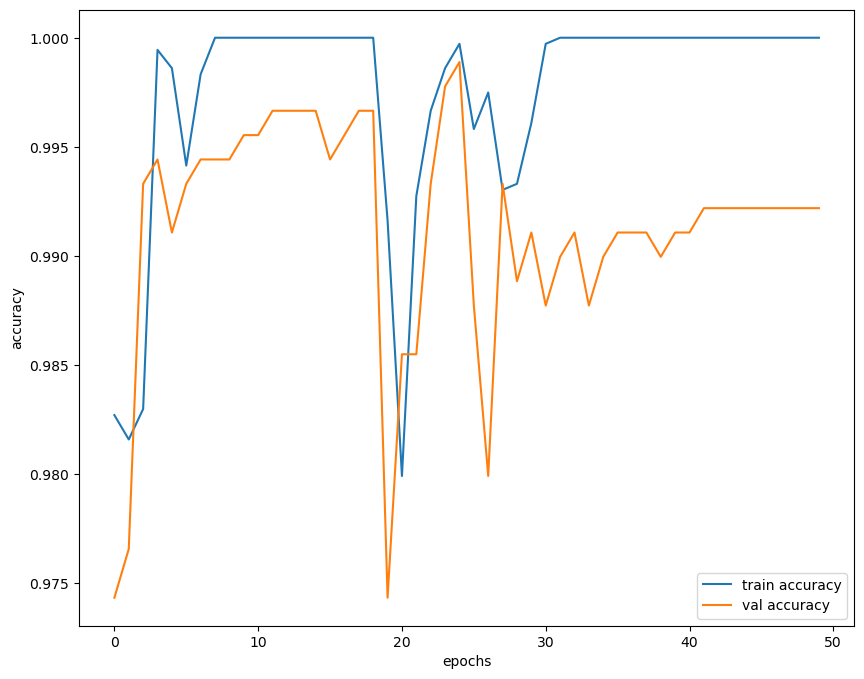

In [31]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(10,8))
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix as cf

y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


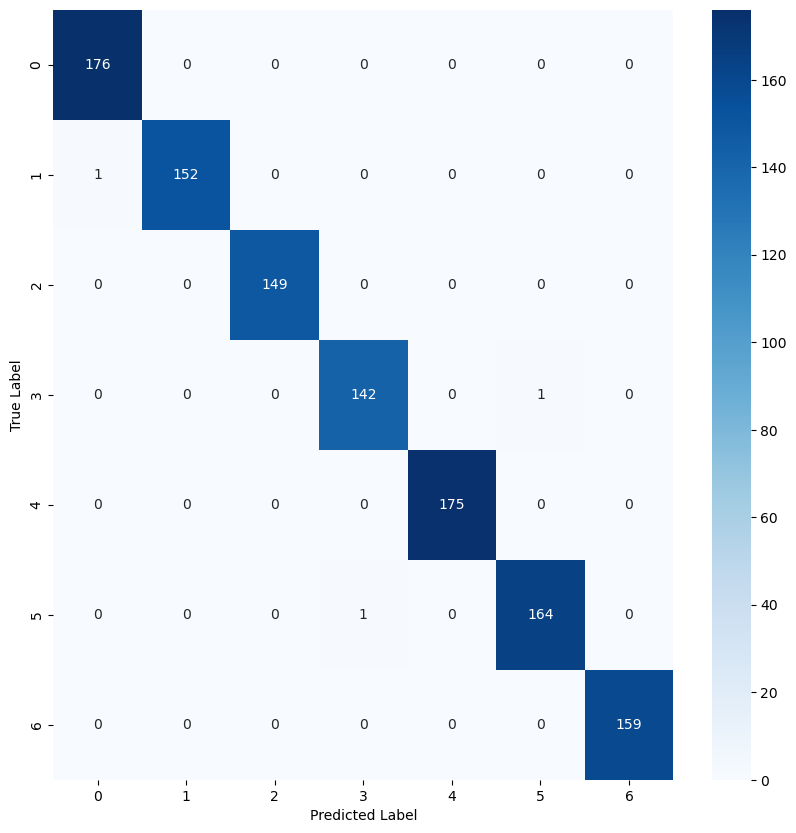

In [25]:
cm = cf(y_true_labels, y_pred_labels)

# Visualisasikan dengan heatmap
plt.figure(figsize=(10,10))
cf_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [30]:
model.save("speech.keras")